In [1]:
!pip install keras-tcn

In [28]:
from tcn import TCN
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from joblib import dump
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import joblib

In [32]:
pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 93.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 148.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.2
    Uninstalling wrapt-1.17.2:
      Successfully uninstalled wrapt-1.17.2
  Attempting uninstall: ml-dtypes
    Found existing installation: ml_dtypes 0.5.1
    Uninstalling ml_dtypes-0.5.1:
      Successfully uninstalled ml_dtypes-0.5.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    

In [3]:
X_train = pd.read_csv("../../../Split Data/Training Dataset/X_train #2.csv").drop(columns=["Unnamed: 0"])
y_train = pd.read_csv("../../../Split Data/Training Dataset/y_train #2.csv", index_col=0)
X_val = pd.read_csv("../../../Split Data/Validation Dataset/X_val #2.csv").drop(columns=["Unnamed: 0"])
y_val = pd.read_csv("../../../Split Data/Validation Dataset/y_val #2.csv", index_col=0)
X_test = pd.read_csv("../../../Split Data/Testing Dataset/X_test #2.csv").drop(columns=["Unnamed: 0"])
y_test = pd.read_csv("../../../Split Data/Testing Dataset/y_test #2.csv", index_col=0)

In [5]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  
X_val_scaled = scaler.transform(X_val)   
X_test_scaled = scaler.transform(X_test) 

joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

In [6]:
X_train = np.array(X_train_scaled).reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)  
X_val = np.array(X_val_scaled).reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)  
X_test = np.array(X_test_scaled).reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)  

In [7]:
num_classes = 2   
kernel_size = 5
dilations = [4, 8, 16, 32, 64] 
max_len = X_train.shape[1] 
dropout_rate = 0.05

In [8]:
inputs = Input(shape=(max_len, 1))

In [10]:
tcn = TCN(
    nb_filters= 128,
    nb_stacks = 2,
    kernel_size=kernel_size,
    dilations=dilations,
    dropout_rate=dropout_rate,
    use_layer_norm=True,
    return_sequences = True
)(inputs)

In [12]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [13]:
max_pooling = GlobalMaxPooling1D()(tcn)

In [14]:
avg_pooling = GlobalAveragePooling1D()(tcn)

In [15]:
pooling = Concatenate()([max_pooling, avg_pooling])

In [16]:
dense1 = Dense(64, activation= 'relu')(pooling)

In [17]:
dropout1 = Dropout(0.2)(dense1)

In [18]:
outputs = Dense(2, activation='softmax')(dropout1)

In [19]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    p = true_positives / (predicted_positives + K.epsilon())
    r = true_positives / (possible_positives + K.epsilon())
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [20]:
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', f1]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 15, 1)]              0         []                            
                                                                                                  
 tcn_1 (TCN)                 (None, 15, 128)              1565056   ['input_1[0][0]']             
                                                                                                  
 global_max_pooling1d (Glob  (None, 128)                  0         ['tcn_1[0][0]']               
 alMaxPooling1D)                                                                                  
                                                                                                  
 global_average_pooling1d (  (None, 128)                  0         ['tcn_1[0][0]']           

In [21]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

y_train shape: (8001, 2)
y_val shape: (1714, 2)


In [22]:
json_string = model.to_json()
with open('tcn_model_architecture.json', 'w') as json_file:
    json_file.write(json_string)


In [23]:
history = model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val), verbose = 1, 
          callbacks = 
          ModelCheckpoint(filepath="TCN #2.weights.h5", 
          monitor='val_f1', mode='max',save_best_only=True, save_weights_only = True))

Epoch 1/100


2025-04-24 20:49:11.311062: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-04-24 20:49:13.867126: I external/local_xla/xla/service/service.cc:168] XLA service 0x7226e2ff7680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-24 20:49:13.867170: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-04-24 20:49:13.909903: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745527754.121001    4096 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


251/251 [==============================] - 30s 43ms/step - loss: 0.5427 - accuracy: 0.7995 - f1: 0.8003 - val_loss: 0.3545 - val_accuracy: 0.8670 - val_f1: 0.8672
Epoch 2/100
251/251 [==============================] - 9s 36ms/step - loss: 0.3817 - accuracy: 0.8650 - f1: 0.8655 - val_loss: 0.3379 - val_accuracy: 0.8862 - val_f1: 0.8863
Epoch 3/100
251/251 [==============================] - 9s 36ms/step - loss: 0.3604 - accuracy: 0.8726 - f1: 0.8693 - val_loss: 0.3275 - val_accuracy: 0.8897 - val_f1: 0.8897
Epoch 4/100
251/251 [==============================] - 9s 34ms/step - loss: 0.3574 - accuracy: 0.8743 - f1: 0.8748 - val_loss: 0.3300 - val_accuracy: 0.8874 - val_f1: 0.8874
Epoch 5/100
251/251 [==============================] - 9s 34ms/step - loss: 0.3369 - accuracy: 0.8793 - f1: 0.8797 - val_loss: 0.3090 - val_accuracy: 0.8903 - val_f1: 0.8903
Epoch 6/100
251/251 [==============================] - 9s 34ms/step - loss: 0.3360 - accuracy: 0.8808 - f1: 0.8812 - val_loss: 0.3241 - val_a

In [30]:
with open("tcn_model_architecture.json", "r") as f:
    TCN_model = model_from_json(f.read(), custom_objects={"f1": f1})

TCN_model.load_weights("TCN #2.weights.h5")

In [31]:
y_test = to_categorical(y_test, 2)

In [33]:
TCN_model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', f1]
)

In [34]:
results = TCN_model.evaluate(X_test, y_test, verbose = 1)

54/54 [==============================] - 3s 22ms/step - loss: 0.2932 - accuracy: 0.8997 - f1: 0.8997


In [35]:
y_pred = TCN_model.predict(X_test)

54/54 [==============================] - 2s 16ms/step


In [36]:
y_test = y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)

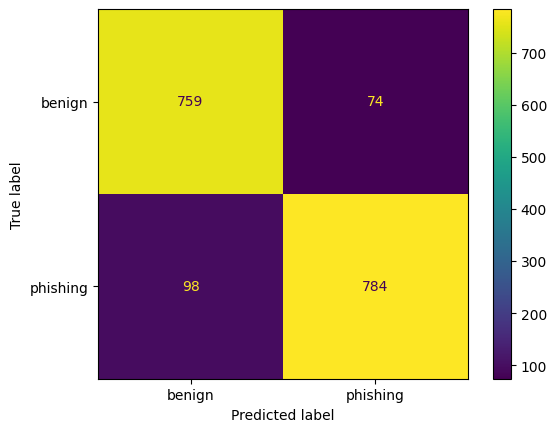

In [37]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["benign", "phishing"])                            
matrix.plot()

In [38]:
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)
F1_score = metrics.f1_score(y_test, y_pred)

In [39]:
print({"Accuracy":Accuracy,"Precision":Precision,"Recall":Recall,"F1_score":F1_score})

{'Accuracy': 0.8997084548104957, 'Precision': 0.9137529137529138, 'Recall': 0.8888888888888888, 'F1_score': 0.9011494252873563}


In [2]:
df = pd.read_csv("../Metrics of Dataset #2.csv")

In [41]:
metrics = pd.DataFrame({"Model": "TCN", "Accuracy": [Accuracy], "Precision":[Precision], "Recall": [Recall], "F1_score": [F1_score]})

In [44]:
df = pd.concat([df, metrics], ignore_index=True)

In [3]:
df.head()

,Model,Accuracy,Precision,Recall,F1_score
0,LinearSVC,0.869388,0.859956,0.891156,0.875278
1,Random Forest,0.900875,0.913953,0.891156,0.902411
2,XGBoost,0.895044,0.892617,0.904762,0.898649
3,MLP,0.896210,0.893736,0.905896,0.899775
4,TCN,0.899708,0.913753,0.888889,0.901149


In [46]:
df.to_csv("../Metrics of Dataset #2.csv", index=False)